<a href="https://colab.research.google.com/github/ArnyWu/-Preview-AI-/blob/main/week11%E4%BD%9C%E6%A5%AD_%E5%A4%9A%E6%A8%A1%E6%85%8B_Multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import os

In [ ]:
# 輸入股票代號
stock_id = "3231.TW"  # 緯創

# 10年的資料
start = dt.datetime(2015, 11, 11)
end = dt.datetime(2024, 11, 11)
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位轉為datetime格式
stock_data["Date"] = pd.to_datetime(stock_data["Date"])
# 將日期欄位設為索引
stock_data.set_index("Date", inplace=True)
# 刪除 Ticker 欄位並取代
stock_data.columns = stock_data.columns.droplevel('Ticker')
stock_data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-11-11 00:00:00+00:00,8.931565,14.245772,14.887061,14.199966,14.841255,17075145
2015-11-12 00:00:00+00:00,8.931565,14.245772,14.474804,14.108353,14.245772,10412313
2015-11-13 00:00:00+00:00,8.816689,14.062547,14.337385,13.925128,14.199966,8769527
2015-11-16 00:00:00+00:00,8.902845,14.199966,14.199966,13.833515,13.879322,8169174
2015-11-17 00:00:00+00:00,9.161315,14.612223,14.749642,14.474804,14.658029,9189775
...,...,...,...,...,...,...
2024-11-04 00:00:00+00:00,116.000000,116.000000,117.000000,114.500000,115.500000,51784516
2024-11-05 00:00:00+00:00,118.500000,118.500000,120.000000,115.000000,116.000000,74142419
2024-11-06 00:00:00+00:00,119.500000,119.500000,121.500000,118.000000,119.500000,75434472


In [ ]:
# 生成周數據
weekly_data = stock_data.resample('W').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

# 生成月數據
monthly_data = stock_data.resample('M').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

# 顯示資料檢查
print(weekly_data.head())
print(monthly_data.head())

Price                           Open       High        Low      Close  \
Date                                                                    
2015-11-15 00:00:00+00:00  14.841255  14.887061  13.925128  14.062547   
2015-11-22 00:00:00+00:00  13.879322  14.841255  13.833515  14.612223   
2015-11-29 00:00:00+00:00  14.841255  15.665769  14.658029  15.528350   
2015-12-06 00:00:00+00:00  15.528350  15.940607  15.161899  15.574156   
2015-12-13 00:00:00+00:00  15.711575  18.139313  15.711575  17.498022   

Price                         Volume  
Date                                  
2015-11-15 00:00:00+00:00   36256985  
2015-11-22 00:00:00+00:00   45467500  
2015-11-29 00:00:00+00:00   68933681  
2015-12-06 00:00:00+00:00   65689589  
2015-12-13 00:00:00+00:00  241556059  
Price                           Open       High        Low      Close  \
Date                                                                    
2015-11-30 00:00:00+00:00  14.841255  15.665769  13.833515  15.619963

<ipython-input-35-dca81025acf5>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = stock_data.resample('M').agg({


In [ ]:
!pip install mplfinance

In [ ]:
import mplfinance as mpf

# 自定義 K 線圖風格
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='charles', marketcolors=my_color)

In [ ]:
def add_technical_indicators(data):
    # 計算均線與指標
    data["5_SMA"] = data["Close"].rolling(window=5).mean()
    data["10_SMA"] = data["Close"].rolling(window=10).mean()
    data["20_SMA"] = data["Close"].rolling(window=20).mean()
    data["26_EMA"] = data["Close"].ewm(span=26, adjust=False).mean()
    data["12_EMA"] = data["Close"].ewm(span=12, adjust=False).mean()
    data["MACD"] = data["12_EMA"] - data["26_EMA"]
    data["Signal"] = data["MACD"].ewm(span=9, adjust=False).mean()

    # 計算 ATR (Average True Range)
    high_low = data["High"] - data["Low"]
    high_close = abs(data["High"] - data["Close"].shift(1))
    low_close = abs(data["Low"] - data["Close"].shift(1))
    true_range = high_low.combine(high_close, max).combine(low_close, max)
    data["ATR"] = true_range.rolling(window=14).mean()

    # 設定標註邏輯
    # 1. MACD_Label
    data["MACD_Label"] = np.where(data["MACD"] > data["Signal"], 1, 0)

    # 2. SMA_Label
    data["SMA_Label"] = np.where(
        (data["5_SMA"] > data["10_SMA"]) & (data["5_SMA"] > data["20_SMA"]), 1, 0
    )

    # 4. 綜合標註 Label
    data['Label'] = np.where(
        (data['MACD_Label'] + data['SMA_Label']) / 2 > 0.5,
        1,
        0
    )
    print(data)
    return data

In [ ]:
# 創建輸出資料夾
os.makedirs("kline_images_daily", exist_ok=True)
os.makedirs("kline_images_weekly", exist_ok=True)
os.makedirs("kline_images_monthly", exist_ok=True)

# 定義自訂 K 線圖風格
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='charles', marketcolors=my_color)

# 設定滑動窗口大小
N_daily = 20  # 20 天
N_weekly = 20  # 20 周
N_monthly = 20  # 20 個月

In [ ]:
# 生成日資料集
daily_images = []
daily_labels = []

# 生成日技術指標
daily_data = add_technical_indicators(stock_data)
# 移除 10_SMA 為 0 的行
daily_data = daily_data.dropna()
print(daily_data)

for i in range(len(stock_data) - N_daily):
    subset = daily_data.iloc[i:i + N_daily]
    label = subset["Label"].iloc[-1]  # 使用綜合標註
    daily_labels.append(label)
    path = f"kline_images_daily/kline_daily_{i}.png"
    mpf.plot(subset, type="candle", style=my_style, savefig=path, title="Daily K-line")
    daily_images.append(path)

Price                       Adj Close       Close        High         Low  \
Date                                                                        
2015-11-11 00:00:00+00:00    8.931565   14.245772   14.887061   14.199966   
2015-11-12 00:00:00+00:00    8.931565   14.245772   14.474804   14.108353   
2015-11-13 00:00:00+00:00    8.816689   14.062547   14.337385   13.925128   
2015-11-16 00:00:00+00:00    8.902845   14.199966   14.199966   13.833515   
2015-11-17 00:00:00+00:00    9.161315   14.612223   14.749642   14.474804   
...                               ...         ...         ...         ...   
2024-11-04 00:00:00+00:00  116.000000  116.000000  117.000000  114.500000   
2024-11-05 00:00:00+00:00  118.500000  118.500000  120.000000  115.000000   
2024-11-06 00:00:00+00:00  119.500000  119.500000  121.500000  118.000000   
2024-11-07 00:00:00+00:00  120.000000  120.000000  120.500000  118.500000   
2024-11-08 00:00:00+00:00  123.500000  123.500000  125.500000  121.000000   

In [ ]:
# 生成周資料集
weekly_data = stock_data.resample("W").agg({
    "Open": "first", "High": "max", "Low": "min", "Close": "last", "Volume": "sum"
})
weekly_data = add_technical_indicators(weekly_data)
weekly_data = weekly_data.dropna()
print(weekly_data)

weekly_images = []
weekly_labels = []
for i in range(len(weekly_data) - N_weekly):
    subset = weekly_data.iloc[i:i + N_weekly]
    label = subset["Label"].iloc[-1]  # 使用綜合標註
    weekly_labels.append(label)
    path = f"kline_images_weekly/kline_weekly_{i}.png"
    mpf.plot(subset, type="candle", style=my_style, savefig=path, title="Weekly K-line")
    weekly_images.append(path)

Price                            Open        High         Low       Close  \
Date                                                                        
2015-11-15 00:00:00+00:00   14.841255   14.887061   13.925128   14.062547   
2015-11-22 00:00:00+00:00   13.879322   14.841255   13.833515   14.612223   
2015-11-29 00:00:00+00:00   14.841255   15.665769   14.658029   15.528350   
2015-12-06 00:00:00+00:00   15.528350   15.940607   15.161899   15.574156   
2015-12-13 00:00:00+00:00   15.711575   18.139313   15.711575   17.498022   
...                               ...         ...         ...         ...   
2024-10-13 00:00:00+00:00  102.000000  109.000000  100.500000  108.500000   
2024-10-20 00:00:00+00:00  109.500000  113.000000  106.500000  109.000000   
2024-10-27 00:00:00+00:00  110.000000  116.000000  109.500000  115.000000   
2024-11-03 00:00:00+00:00  116.000000  116.500000  107.500000  115.000000   
2024-11-10 00:00:00+00:00  115.500000  125.500000  114.500000  123.500000   

In [ ]:
# 生成月資料集
monthly_data = stock_data.resample("M").agg({
    "Open": "first", "High": "max", "Low": "min", "Close": "last", "Volume": "sum"
})
monthly_data = add_technical_indicators(monthly_data)
monthly_data = monthly_data.dropna()
print(weekly_data)

monthly_images = []
monthly_labels = []
for i in range(len(monthly_data) - N_monthly):
    subset = monthly_data.iloc[i:i + N_monthly]
    label = subset["Label"].iloc[-1]  # 使用綜合標註
    monthly_labels.append(label)
    path = f"kline_images_monthly/kline_monthly_{i}.png"
    mpf.plot(subset, type="candle", style=my_style, savefig=path, title="Monthly K-line")
    monthly_images.append(path)

<ipython-input-42-c2ee2aef3cdc>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = stock_data.resample("M").agg({


Price                            Open        High         Low       Close  \
Date                                                                        
2015-11-30 00:00:00+00:00   14.841255   15.665769   13.833515   15.619963   
2015-12-31 00:00:00+00:00   15.757382   19.238665   15.299318   17.039959   
2016-01-31 00:00:00+00:00   17.223185   17.314796   14.245772   17.177378   
2016-02-29 00:00:00+00:00   17.314796   18.139313   16.261251   18.139313   
2016-03-31 00:00:00+00:00   18.093506   21.070917   17.268991   18.230925   
...                               ...         ...         ...         ...   
2024-07-31 00:00:00+00:00  106.500000  114.000000   93.699997   96.800003   
2024-08-31 00:00:00+00:00   98.800003  105.500000   83.199997  101.500000   
2024-09-30 00:00:00+00:00  102.500000  106.000000   92.599998  101.000000   
2024-10-31 00:00:00+00:00  101.500000  116.500000  100.000000  111.000000   
2024-11-30 00:00:00+00:00  107.500000  125.500000  107.500000  123.500000   

In [ ]:
# 儲存標註資料集
pd.DataFrame({"image": daily_images, "label": daily_labels}).to_csv("daily_labels.csv", index=False)
pd.DataFrame({"image": weekly_images, "label": weekly_labels}).to_csv("weekly_labels.csv", index=False)
pd.DataFrame({"image": monthly_images, "label": monthly_labels}).to_csv("monthly_labels.csv", index=False)

In [ ]:
# 定義一個函數來處理技術指標的縮放
def process_technical_features(data, filename):
    # 選擇技術指標
    technical_features = data[["Open", "ATR", "Volume"]].fillna(0)

    # 縮放到 [0, 1]
    scaler = MinMaxScaler()
    technical_features_scaled = scaler.fit_transform(technical_features)

    # 儲存為 DataFrame 並輸出到 CSV
    technical_features_df = pd.DataFrame(technical_features_scaled, columns=["Open", "ATR", "Volume"])
    technical_features_df.to_csv(filename, index=False)
    print(f"{filename} 技術指標已縮放並保存完成")


# 日技術指標
process_technical_features(stock_data, "technical_features_daily.csv")

# 周技術指標
process_technical_features(weekly_data, "technical_features_weekly.csv")

# 月技術指標
process_technical_features(monthly_data, "technical_features_monthly.csv")


technical_features_daily.csv 技術指標已縮放並保存完成
technical_features_weekly.csv 技術指標已縮放並保存完成
technical_features_monthly.csv 技術指標已縮放並保存完成


In [ ]:
class KLineDatasetWithFeatures(Dataset):
    def __init__(self, csv_file, root_dir, features_file, transform=None, time_steps=3):
        self.labels_df = pd.read_csv(csv_file)
        self.features_df = pd.read_csv(features_file) # 僅加載所需技術指標
        self.root_dir = root_dir.rstrip("/")  # 確保目錄路徑結尾沒有多餘的 "/"
        self.transform = transform
        self.time_steps = time_steps  # 時間步數

    def __len__(self):
        return len(self.labels_df) // self.time_steps  # 每 time_steps 步作為一組

    def __getitem__(self, idx):
        start_idx = idx * self.time_steps
        end_idx = start_idx + self.time_steps

        # 邊界檢查
        if end_idx > len(self.labels_df):
            raise IndexError(f"Index {end_idx} is out of bounds for dataset with length {len(self.labels_df)}")

        # 圖像部分
        images = []
        for i in range(start_idx, end_idx):
            img_name = os.path.join(self.root_dir, self.labels_df.iloc[i, 0])
            image = Image.open(img_name).convert("RGB")
            if self.transform:
                image = self.transform(image)
            images.append(image)
        images = torch.stack(images)

        # 數值特徵部分
        features = []
        for i in range(start_idx, end_idx):
            feature = torch.tensor(self.features_df.iloc[i].values, dtype=torch.float32)
            features.append(feature)
        features = torch.stack(features)

        # 標籤部分
        label = self.labels_df.iloc[end_idx - 1, 1]

        return images, features, label


# 定義圖像轉換
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 調整圖像大小為 224x224
    transforms.ToTensor(),          # 轉換為 PyTorch 張量
])


In [ ]:
# 日資料
daily_dataset = KLineDatasetWithFeatures(
    csv_file="daily_labels.csv",
    root_dir="/content",
    features_file="technical_features_daily.csv",
    transform=transform
)

# 周資料
weekly_dataset = KLineDatasetWithFeatures(
    csv_file="weekly_labels.csv",
    root_dir="/content",
    features_file="technical_features_weekly.csv",
    transform=transform
)

# 月資料
monthly_dataset = KLineDatasetWithFeatures(
    csv_file="monthly_labels.csv",
    root_dir="/content",
    features_file="technical_features_monthly.csv",
    transform=transform
)

In [ ]:
print(f"Features DataFrame length: {len(weekly_dataset.features_df)}")
print(f"Labels DataFrame length: {len(weekly_dataset.labels_df)}")

Features DataFrame length: 357
Labels DataFrame length: 337


In [ ]:
# 測試日資料集
daily_loader = DataLoader(daily_dataset, batch_size=32, shuffle=True)
for images, features, labels in daily_loader:
    print(f"Daily: Images shape: {images.shape}, Features shape: {features.shape}, Labels shape: {labels.shape}")
    break

# 測試周資料集
weekly_loader = DataLoader(weekly_dataset, batch_size=32, shuffle=True)
print(f"Weekly data length: {len(weekly_data)}")

for images, features, labels in weekly_loader:
    print(f"Weekly: Images shape: {images.shape}, Features shape: {features.shape}, Labels shape: {labels.shape}")
    break

# 測試月資料集
monthly_loader = DataLoader(monthly_dataset, batch_size=32, shuffle=True)
for images, features, labels in monthly_loader:
    print(f"Monthly: Images shape: {images.shape}, Features shape: {features.shape}, Labels shape: {labels.shape}")
    break

Daily: Images shape: torch.Size([32, 3, 3, 224, 224]), Features shape: torch.Size([32, 3, 3]), Labels shape: torch.Size([32])
Weekly data length: 357
Weekly: Images shape: torch.Size([32, 3, 3, 224, 224]), Features shape: torch.Size([32, 3, 3]), Labels shape: torch.Size([32])
Monthly: Images shape: torch.Size([23, 3, 3, 224, 224]), Features shape: torch.Size([23, 3, 3]), Labels shape: torch.Size([23])


In [ ]:
class SimpleCNNLSTMModel(nn.Module):
    def __init__(self):
        super(SimpleCNNLSTMModel, self).__init__()
        # CNN 部分
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # 數值特徵處理
        self.fc_features = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU()
        )

        # LSTM 部分
        self.lstm = nn.LSTM(input_size=32 + 32, hidden_size=32, num_layers=2, batch_first=True, dropout=0.3)

        # 融合層
        self.fc_fusion = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, images, features):
        batch_size, time_steps, _, _, _ = images.size()

        cnn_out = []
        for t in range(time_steps):
            cnn_feature = self.cnn(images[:, t, :, :, :])
            cnn_feature = cnn_feature.view(batch_size, -1)
            cnn_out.append(cnn_feature)
        cnn_out = torch.stack(cnn_out, dim=1)

        features_out = []
        for t in range(time_steps):
            features_out.append(self.fc_features(features[:, t, :]))
        features_out = torch.stack(features_out, dim=1)

        combined_features = torch.cat((cnn_out, features_out), dim=2)

        lstm_out, _ = self.lstm(combined_features)
        lstm_out = lstm_out[:, -1, :]

        output = self.fc_fusion(lstm_out)
        return output

In [ ]:
!pip install torchinfo

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=5b1fda5ce33b7b8ed319b0b40e0fd3fe0296426b036ea79490de8b874ef5b6de
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
from torchviz import make_dot
# 模擬圖像和數值特徵輸入
# 模擬輸入
images = torch.randn(32, 3, 3, 224, 224)  # [batch_size, time_steps, channels, height, width]
features = torch.randn(32, 3, 3)          # [batch_size, time_steps, num_features]

# 建立模型實例
model = SimpleCNNLSTMModel()
# 檢查模型的輸出
output = model(images, features)
print("模型輸出形狀:", output.shape)

# 繪製計算圖
dot = make_dot(output, params=dict(list(model.named_parameters())))
dot.render("model_architecture", format="png")  # 將流程圖保存為 PNG

# 顯示每層輸出的形狀
from torchinfo import summary
summary(model, input_data=(images, features), col_names=["input_size", "output_size", "num_params"])

模型輸出形狀: torch.Size([32, 2])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SimpleCNNLSTMModel                       [32, 3, 3, 224, 224]      [32, 2]                   --
├─Sequential: 1-1                        [32, 3, 224, 224]         [32, 32, 1, 1]            --
│    └─Conv2d: 2-1                       [32, 3, 224, 224]         [32, 16, 224, 224]        448
│    └─ReLU: 2-2                         [32, 16, 224, 224]        [32, 16, 224, 224]        --
│    └─MaxPool2d: 2-3                    [32, 16, 224, 224]        [32, 16, 112, 112]        --
│    └─Conv2d: 2-4                       [32, 16, 112, 112]        [32, 32, 112, 112]        4,640
│    └─ReLU: 2-5                         [32, 32, 112, 112]        [32, 32, 112, 112]        --
│    └─AdaptiveAvgPool2d: 2-6            [32, 32, 112, 112]        [32, 32, 1, 1]            --
├─Sequential: 1-2                        [32, 3, 224, 224]         [32, 32, 1, 1]            (recursive)
│    └─Conv2d: 2-7    

In [ ]:
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset

from sklearn.model_selection import train_test_split

# 合併日、周、月資料
combined_dataset = ConcatDataset([daily_dataset, weekly_dataset, monthly_dataset])

# 建立索引
indices = list(range(len(combined_dataset)))

# 分割成訓練集 (80%) 和剩餘資料 (20%)
train_indices, temp_indices = train_test_split(indices, test_size=0.2, random_state=42)

# 分割剩餘資料成驗證集 (50%) 和測試集 (50%)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# 創建子集
train_dataset = Subset(combined_dataset, train_indices)
val_dataset = Subset(combined_dataset, val_indices)
test_dataset = Subset(combined_dataset, test_indices)

# 建立 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
from collections import Counter

train_labels = []
for _, _, labels in train_loader:
    train_labels.extend(labels.tolist())
print("訓練集標籤分佈:", Counter(train_labels))

val_labels = []
for _, _, labels in val_loader:
    val_labels.extend(labels.tolist())
print("驗證集標籤分佈:", Counter(val_labels))

test_labels = []
for _, _, labels in test_loader:
    test_labels.extend(labels.tolist())
print("測試集標籤分佈:", Counter(test_labels))


訓練集標籤分佈: Counter({0: 415, 1: 270})
驗證集標籤分佈: Counter({0: 48, 1: 38})
測試集標籤分佈: Counter({0: 52, 1: 34})


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR

# 初始化模型、優化器和設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNNLSTMModel().to(device)
criterion = nn.CrossEntropyLoss()
# 使用 Adam 優化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # 常用參數
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
#optimizer = optim.RMSprop(model.parameters(), lr=0.5, alpha=0.88, weight_decay=1e-4)

# 初始化學習率調整器
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

#scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=num_epochs)
# 訓練函數
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    for images, features, labels in loader:
        images, features, labels = images.to(device), features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, features)
        loss = criterion(outputs, labels)  # 使用 criterion 計算損失
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader), accuracy

# 驗證函數
def validate_epoch_with_metrics(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, features, labels in loader:
            images, features, labels = images.to(device), features.to(device), labels.to(device)
            outputs = model(images, features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 計算準確率
    accuracy = correct / len(loader.dataset)

    return total_loss / len(loader), accuracy

# 初始化記錄列表
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# 訓練過程
num_epochs = 20

#scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate_epoch_with_metrics(model, val_loader, criterion, device)

    # 使用調度器根據驗證損失調整學習率
    scheduler.step(val_loss)

    # 記錄數據
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20
Train Loss: 0.6734, Train Acc: 0.6058
Val Loss: 0.6934, Val Acc: 0.5581
Epoch 2/20
Train Loss: 0.6717, Train Acc: 0.6058
Val Loss: 0.6956, Val Acc: 0.5581
Epoch 3/20
Train Loss: 0.6709, Train Acc: 0.6058
Val Loss: 0.6990, Val Acc: 0.5581
Epoch 4/20
Train Loss: 0.6704, Train Acc: 0.6058
Val Loss: 0.6992, Val Acc: 0.5581
Epoch 5/20
Train Loss: 0.6704, Train Acc: 0.6058
Val Loss: 0.6994, Val Acc: 0.5581
Epoch 6/20
Train Loss: 0.6703, Train Acc: 0.6058
Val Loss: 0.6994, Val Acc: 0.5581
Epoch 7/20
Train Loss: 0.6700, Train Acc: 0.6058
Val Loss: 0.6994, Val Acc: 0.5581
Epoch 8/20
Train Loss: 0.6705, Train Acc: 0.6058
Val Loss: 0.6994, Val Acc: 0.5581
Epoch 9/20
Train Loss: 0.6707, Train Acc: 0.6058
Val Loss: 0.6994, Val Acc: 0.5581
Epoch 10/20
Train Loss: 0.6704, Train Acc: 0.6058
Val Loss: 0.6994, Val Acc: 0.5581
Epoch 11/20
Train Loss: 0.6705, Train Acc: 0.6058
Val Loss: 0.6994, Val Acc: 0.5581
Epoch 12/20
Train Loss: 0.6703, Train Acc: 0.6058
Val Loss: 0.6994, Val Acc: 0.5581
E

In [ ]:
def test_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, labels in loader:
            images, features, labels = images.to(device), features.to(device), labels.to(device)
            outputs = model(images, features)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return accuracy

test_acc = test_model(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6047


Text(0.5, 1.0, 'Accuracy over Epochs')

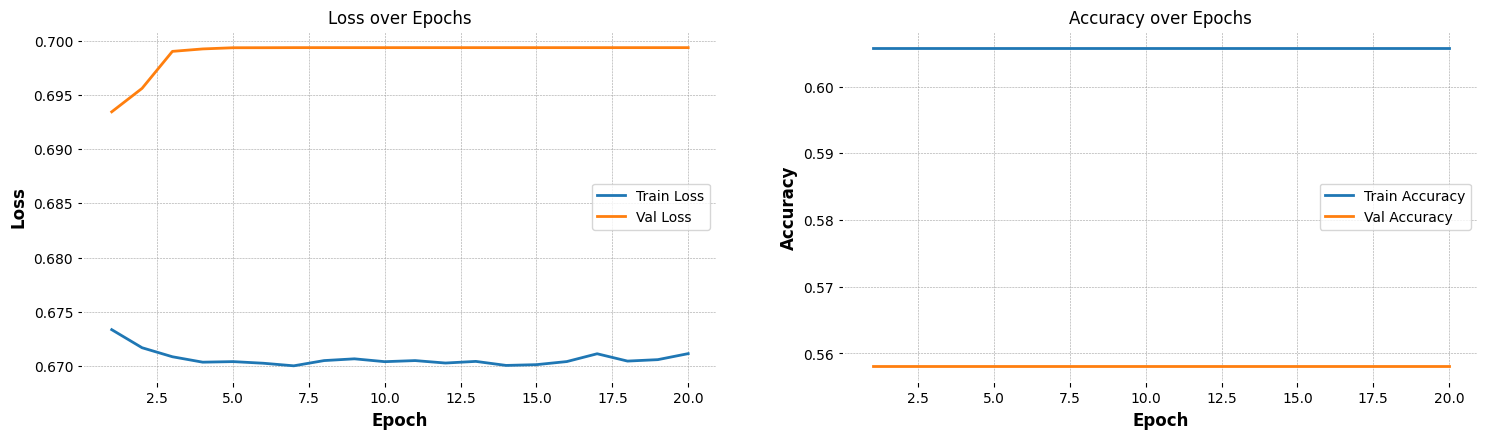

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

# 繪製損失曲線
plt.subplot(2, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")

# 繪製準確率曲線
plt.subplot(2, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")

Sample 35:
True Label: 1 | Predicted Label: 0


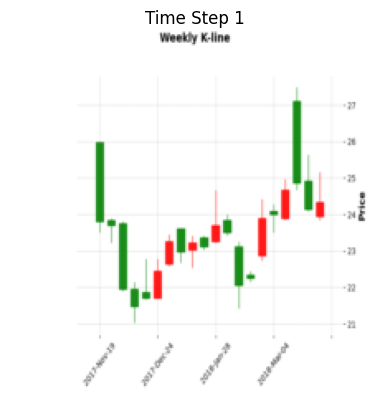

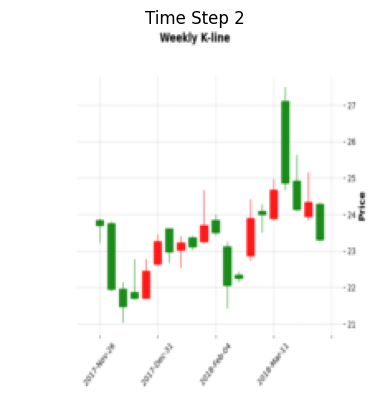

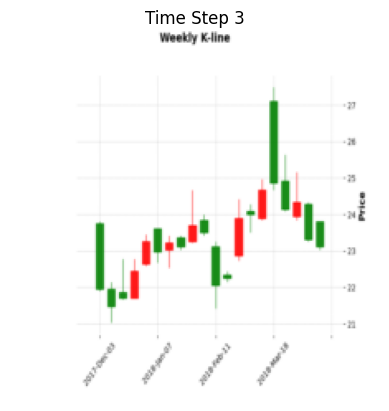

Numerical Features at Each Time Step:
tensor([[0.0600, 0.0401, 0.0812],
        [0.0449, 0.0369, 0.0860],
        [0.0442, 0.0401, 0.1195]])
--------------------------------------------------
Sample 23:
True Label: 0 | Predicted Label: 0


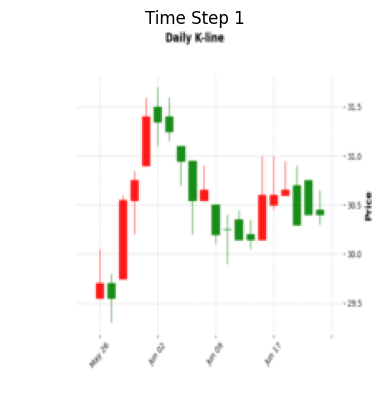

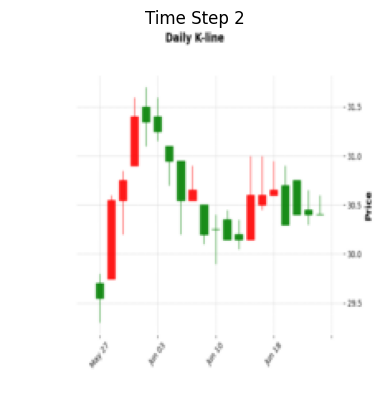

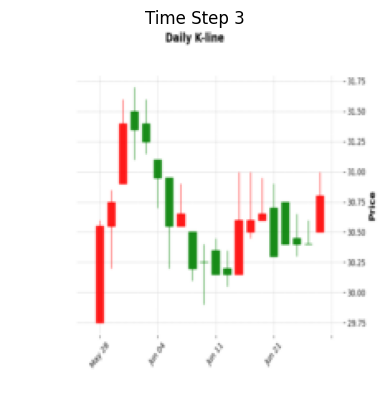

Numerical Features at Each Time Step:
tensor([[0.1276, 0.0311, 0.0342],
        [0.1279, 0.0305, 0.0394],
        [0.1255, 0.0347, 0.0823]])
--------------------------------------------------
Sample 59:
True Label: 0 | Predicted Label: 0


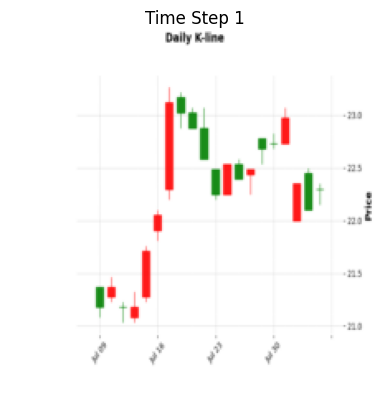

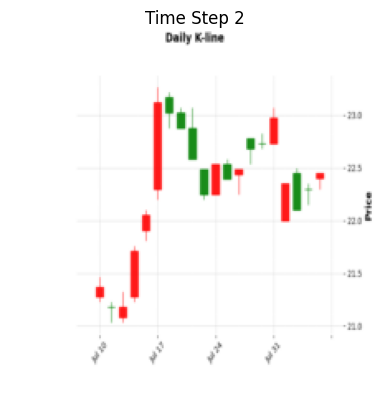

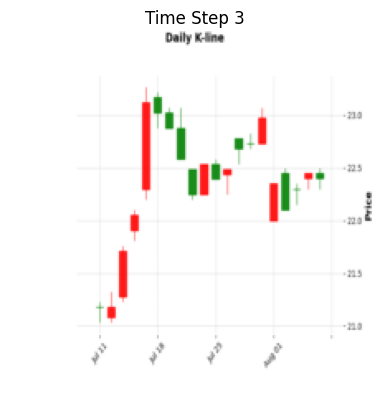

Numerical Features at Each Time Step:
tensor([[0.0615, 0.0247, 0.0309],
        [0.0608, 0.0241, 0.0314],
        [0.0602, 0.0258, 0.0432]])
--------------------------------------------------


In [ ]:
import numpy as np

def display_predictions(model, loader, device, num_samples=5):
    """
    展示模型對測試數據的預測與真實標籤
    """
    model.eval()  # 設置模型為評估模式
    all_images, all_features, all_labels, all_preds = [], [], [], []

    with torch.no_grad():
        for images, features, labels in loader:
            images, features, labels = images.to(device), features.to(device), labels.to(device)
            outputs = model(images, features)
            preds = outputs.argmax(dim=1)

            # 保存結果
            all_images.append(images.cpu())
            all_features.append(features.cpu())
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    # 合併批次
    all_images = torch.cat(all_images)
    all_features = torch.cat(all_features)
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)

    # 隨機選取一些樣本展示
    indices = np.random.choice(len(all_labels), num_samples, replace=False)
    for idx in indices:
        print(f"Sample {idx+1}:")
        print(f"True Label: {all_labels[idx].item()} | Predicted Label: {all_preds[idx].item()}")

        # 可視化圖像部分
        time_steps = all_images[idx].shape[0]  # 時間步
        for t in range(time_steps):
            plt.imshow(all_images[idx][t].permute(1, 2, 0))  # [C, H, W] -> [H, W, C]
            plt.axis("off")
            plt.title(f"Time Step {t+1}")
            plt.show()

        print("Numerical Features at Each Time Step:")
        print(all_features[idx])
        print("-" * 50)
# 測試數據集上的結果展示
display_predictions(model, test_loader, device, num_samples=3)